In [1]:
#utility
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

In [224]:
# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC

# metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,KFold,cross_val_score,learning_curve
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.metrics import make_scorer, accuracy_score,balanced_accuracy_score,log_loss,f1_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# feature importances
#from pdpbox import pdp, get_dataset, info_plots
#import shap
#import eli5
#from eli5.sklearn import PermutationImportance

# Dataset

In [121]:
df = pd.read_csv('adult.csv')
df.head(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


### replace ? values

In [122]:
# replace missing values with labels
df.workclass.replace({"?":'Unkown'},inplace=True)
df.occupation.replace({"?":'Unkown'},inplace=True)
df['native.country'].replace({"?":'Unkown'},inplace=True)

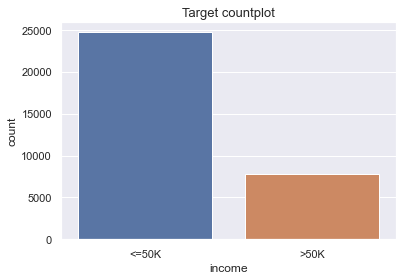

In [123]:
# see if the dataset is imbalanced
sns.countplot(df.income)
plt.title('Target countplot',size=13)
plt.show()

# Features Engineering

In [124]:
temp=df.drop('income',1)
# one hot encoding 
data=pd.get_dummies(temp)
data['target']=df.income
# map target values
data['target']= data['target'].map({"<=50K":0,">50K":1})
data.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Unkown,native.country_Vietnam,native.country_Yugoslavia,target
0,90,77053,9,0,4356,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,82,132870,9,0,4356,18,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,66,186061,10,0,4356,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,54,140359,4,0,3900,40,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,41,264663,10,0,3900,40,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


# Machine learning

In [125]:
# train test split
ml_df = data.copy()
X= ml_df.drop('target',1)
y= ml_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Since we're dealing with medium imbalanced dataset  we must try different approaches:

1. Select a better evaluation metrics (precision,recall,roc_auc,f1 score)
2. Use an oversampling technique

For now let'see how models work on imbalanced dataset, evaluating their performance with recall score, later we will see how SMOTE technique perform and how improve model performance

# Compare accuracy for different models

Logistic Regression
Recall : 0.502293 (Standard Deviation 0.176452)
____________________________________________________________
Decision Tree
Recall : 0.767754 (Standard Deviation 0.157969)
____________________________________________________________


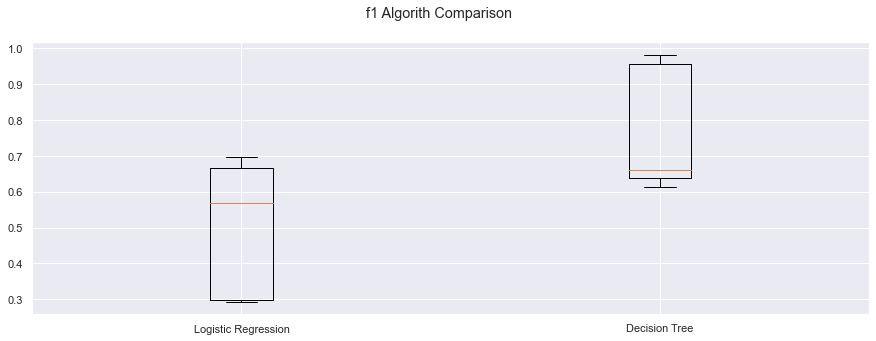

In [139]:
results = []
names = []
models = []

models.append(('Logistic Regression', LogisticRegression(max_iter=100000)))
models.append(('Decision Tree', DecisionTreeClassifier()))
#models.append(('Support Vector', SVC()))
#models.append(('Gradient Boosting', GradientBoostingClassifier()))
#models.append(('XGB', XGBClassifier()))

for name,model in models:
        kfold= KFold(10)
        cv_results = cross_val_score(model,X_train_res,y_train_res,cv= kfold,scoring='recall')
        results.append(cv_results)
        names.append(name)
        print(name)
        evaluation = "Recall : %f (Standard Deviation %f)" % (cv_results.mean(), cv_results.std())
        print(evaluation)
        print('_'*60)

        
figure = plt.figure(figsize=(15,5))
figure.suptitle(' f1 Algorith Comparison')
ax = figure.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Learning curve

In [52]:
def plot_learning_curve(X,y,model):
    model=model()
    
    train_sizes, train_scores,test_scores =learning_curve(model,X,y,
                                                         cv=3,scoring='accuracy',n_jobs=-1,
                                                         train_sizes=np.linspace(0.01,1,50))
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    return

### Plot learning curve function

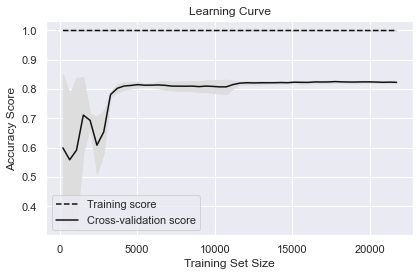

In [53]:
plot_learning_curve(X,y,LogisticRegression)

# Single Model evaluation
Function that returns info and metrics about selected model

In [196]:
def evaluate_model(dataset,model):
    ###
    ml_df = dataset.copy()
    X= ml_df.drop('target',1)
    y= ml_df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    cm=confusion_matrix(y_test,predictions)

    
    print('\033[1m' + '_'*30 +str(model.__class__.__name__) + ' Performance'+ '_'*30)
    print(classification_report(y_test,predictions))
    print('_'*25 +str(model.__class__.__name__) + ' Evaluation Metrics'+ '_'*30)
    print('\n')
    print("Accuracy: %f" % (accuracy_score(y_test,predictions)))
    print("Recall score: %f" % (recall_score(y_test,predictions)))
    print("Log Loss: %f" % (log_loss(y_test,predictions)))
    print("F1 score: %f" % (f1_score(y_test,predictions)))
    print('_'*25 +str(model.__class__.__name__) + ' Confusion Matrix'+ '_'*30)
    
    print('\n')
    print('Number of observations in test set : '+ str(len(y_test)))
    print('Percentage of correct answers on test set: '+ str(round((cm[0,0]+cm[1,1])/len(y_test),2)))
    print('Percentage of wrong answers on test set : '+ str(round((cm[0,1]+cm[1,0])/len(y_test),2)))
    
    g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Spectral',cbar=False)
    g.set_xticklabels('01',fontsize = 16)
    g.set_yticklabels('01',fontsize = 16)
    plt.xlabel('Actual',size=16)
    plt.ylabel('Predicted',size=16)
    plt.suptitle(str(model.__class__.__name__))
    plt.title('Confusion Matrix',size=10)
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    
    roc_auc = auc(fpr,tpr)
    # Plot ROC
    print('_'*25 +str(model.__class__.__name__) + ' ROC Curve'+ '_'*30)
    
    plt.title(str(model.__class__.__name__))
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc,)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return 

## Select a classifier to see model performance

______________________________GradientBoostingClassifier Performance______________________________
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8150
           1       0.80      0.59      0.68      2596

    accuracy                           0.87     10746
   macro avg       0.84      0.77      0.80     10746
weighted avg       0.86      0.87      0.86     10746

_________________________GradientBoostingClassifier Evaluation Metrics______________________________


Accuracy: 0.865159
Recall score: 0.587057
Log Loss: 4.657267
F1 score: 0.677785
_________________________GradientBoostingClassifier Confusion Matrix______________________________


Number of observations in test set : 10746
Percentage of correct answers on test set: 0.87
Percentage of wrong answers on test set : 0.13


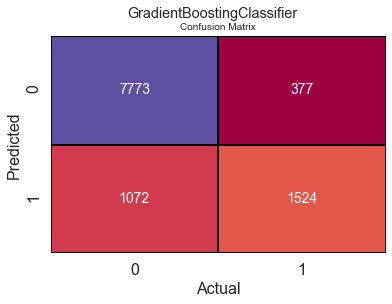

_________________________GradientBoostingClassifier ROC Curve______________________________


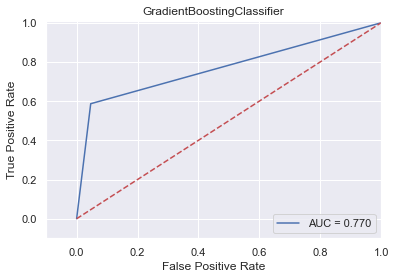

In [222]:
# for this purpose i set manually XGB classifier
xgb= XGBClassifier(objective='binary:logistic',subsample=0.8,colsample_bytree=0.8,random_state=42,
                  max_depth=3,gamma=0.1,min_child_weight=1)

# evaluate xgb
evaluate_model(data,xgb)

# SMOTE

In [219]:
def smote_oversampling(dataset,model):
    
    ml_df = dataset.copy()
    X= ml_df.drop('target',1)
    y= ml_df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    print('\033[1m' + "Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
    print('_'*50)
    sm = SMOTE(random_state=2,sampling_strategy='minority')
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    print('_'*50)
    print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
    model = model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
        
    smote_model=model.fit(X_train_res,y_train_res)
    smote_pred= smote_model.predict(X_test)
    print('-><-'*58)
    print('Improvement for recall score: ',round((recall_score(y_test,smote_pred)-recall_score(y_test,predictions)),3))
    print('Improvement for F1 score: ',round((f1_score(y_test,smote_pred)-f1_score(y_test,predictions)),3))
    print('|'*50)
    print("Recall score : %f" % (recall_score(y_test,predictions)))
    print("F1 score: %f" % (f1_score(y_test,predictions)))
    print('|'*50)
    print("Recall score SMOTE sample: %f" % (recall_score(y_test,smote_pred)))
    print("F1 score SMOTE sample: %f" % (f1_score(y_test,smote_pred)))
    return    

In [220]:
smote_oversampling(data,LogisticRegression())

Before OverSampling, counts of label '1': 5245
Before OverSampling, counts of label '0': 16570
__________________________________________________
After OverSampling, counts of label '1': 16570
After OverSampling, counts of label '0': 16570
__________________________________________________
After OverSampling, the shape of train_X: (33140, 108)
After OverSampling, the shape of train_y: (33140,) 

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Improvement for recall score:  0.266
Improvement for F1 score:  0.049
||||||||||||||||||||||||||||||||||||||||||||||||||
Recall score : 0.263097
F1 score: 0.384789
||||||||||||||||||||||||||||||||||||||||||||||||||
Recall score SMOTE sample: 0.529276
F1 score SMOTE sample: 0.433302
